In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/MyDrive/CS247/Models')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
!pip install surprise
import surprise
from surprise import *
from util import *

     |████████████████████████████████| 11.8MB 261kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617606 sha256=8755d87f7f4fdfcacca9d25a764511b535e8cc23762405aef17b71aa00ae7d20
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from evaluate import *

In [ ]:
train_data = pd.read_pickle("/content/drive/MyDrive/CS247/Data/train_data.pkl")
val_data = pd.read_pickle("/content/drive/MyDrive/CS247/Data/val_data.pkl")
test_data = pd.read_pickle("/content/drive/MyDrive/CS247/Data/test_data.pkl")[['review_profilename','beer_name','review_overall']]
test_data = merge_user_id(test_data, on='review_profilename').rename(columns={'id':'user_id'})
test_data = merge_beer_id(test_data, on='beer_name').rename(columns={'id':'beer_id'})[['user_id','beer_id','review_overall']]

In [ ]:
threshold = 4.0
train_data['relevant'] = (train_data['review_overall'] >= threshold).astype(int)
val_data['relevant'] = (val_data['review_overall'] >= threshold).astype(int)
test_data['relevant'] = (test_data['review_overall'] >= threshold).astype(int)

In [ ]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)
print(train_data.head())
print(val_data.head())
print(test_data.head())

(931875, 4)
(316616, 4)
(300827, 4)
        user_id  beer_id  review_overall  relevant
383941      415      831             3.5         0
483700     2492     3491             4.0         1
375376     1233     1178             4.5         1
705138     1230      902             4.5         1
435972     2290     7497             3.5         0
         user_id  beer_id  review_overall  relevant
1033343     1597     6355             5.0         1
1052177      106    10576             3.5         0
950364        54      484             3.5         0
1244606       35     5319             3.0         0
976342       429      486             4.5         1
   user_id  beer_id  review_overall  relevant
0        0     5892             4.0         1
1        2     5892             4.0         1
2        9     5892             4.0         1
3       12     5892             4.0         1
4       17     5892             5.0         1


In [ ]:
train_user_list = train_data['user_id'].values.tolist()
train_beer_list = train_data['beer_id'].values.tolist()
val_user_list = val_data['user_id'].values.tolist()
val_beer_list = val_data['beer_id'].values.tolist()
test_user_list = test_data['user_id'].values.tolist()
test_beer_list = test_data['beer_id'].values.tolist()
print(len(train_data['user_id'].unique()))
print(len(train_data['beer_id'].unique()))
print("Min user ID of train:",min(train_user_list))
print("Max user ID of train:",max(train_user_list))
print("Min beer ID of train:",min(train_beer_list))
print("Max beer ID of train:",max(train_beer_list))
print("Min user ID of val:",min(val_user_list))
print("Max user ID of val:",max(val_user_list))
print("Min beer ID of val:",min(val_beer_list))
print("Max beer ID of val:",max(val_beer_list))
print("Min user ID of test:",min(test_user_list))
print("Max user ID of test:",max(test_user_list))
print("Min beer ID of test:",min(test_beer_list))
print("Max beer ID of test:",max(test_beer_list))
n_users = len(train_data['user_id'].unique())
n_items = len(train_data['beer_id'].unique())
print(n_users)
print(n_items)

14811
52583
Min user ID of train: 0
Max user ID of train: 14810
Min beer ID of train: 0
Max beer ID of train: 52582
Min user ID of val: 0
Max user ID of val: 14810
Min beer ID of val: 0
Max beer ID of val: 52546
Min user ID of test: 0
Max user ID of test: 14810
Min beer ID of test: 0
Max beer ID of test: 52581
14811
52583


In [ ]:
class MatrixFactorization(nn.Module):
  def __init__(self, n_users, n_items, n_factors=10):
    super().__init__()
    self.user_emb = nn.Embedding(n_users,n_factors,sparse=True)
    self.item_emb = nn.Embedding(n_items,n_factors,sparse=True)
  
  def forward(self, user, item):
    p = self.user_emb(user)
    q = self.item_emb(item)
    return (p*q).sum(1)

  def predict(self, user, item):
    return self.forward(user, item)

In [ ]:
model =  MatrixFactorization(n_users,n_items)
loss_fn = nn.MSELoss() # turn this into RMSE?
optimizer = optim.SparseAdam(model.parameters(),lr=1e-2)
epochs = 60
batch_size = 1280

l = []
for i in range(epochs):
    print("epoch: ",i)
    s = 0
    for bid in range(len(train_data) // batch_size):
        if (bid % 500 == 0):
          print("iteration: ",i, ", batch: ", bid) # there are around 2000 batches per iteration, you may want to print the batch number to check the curret progress
        data = train_data[bid * batch_size : (bid + 1) * batch_size]
        optimizer.zero_grad()

        rating = Variable(torch.FloatTensor(data.review_overall.to_numpy()))
        user_id = Variable(torch.LongTensor(data.user_id.to_numpy()))
        beer_id = Variable(torch.LongTensor(data.beer_id.to_numpy()))
        pred = model.predict(user_id, beer_id)
        loss = loss_fn(pred,rating)

        loss.backward()
        s += loss
        optimizer.step()
    l.append(s.item()/(len(data) // batch_size))
    print("Average Loss for the current iteration: ", l[i])
    print("-----------------------------------")

epoch:  0
iteration:  0 , batch:  0
iteration:  0 , batch:  500
Average Loss for the current iteration:  13822.7119140625
-----------------------------------
epoch:  1
iteration:  1 , batch:  0
iteration:  1 , batch:  500
Average Loss for the current iteration:  6142.26416015625
-----------------------------------
epoch:  2
iteration:  2 , batch:  0
iteration:  2 , batch:  500
Average Loss for the current iteration:  2232.916015625
-----------------------------------
epoch:  3
iteration:  3 , batch:  0
iteration:  3 , batch:  500
Average Loss for the current iteration:  1320.7137451171875
-----------------------------------
epoch:  4
iteration:  4 , batch:  0
iteration:  4 , batch:  500
Average Loss for the current iteration:  931.6136474609375
-----------------------------------
epoch:  5
iteration:  5 , batch:  0
iteration:  5 , batch:  500
Average Loss for the current iteration:  719.066650390625
-----------------------------------
epoch:  6
iteration:  6 , batch:  0
iteration:  6 ,

In [ ]:
label_pred = 'y_pred'
user_id = Variable(torch.LongTensor(test_data.user_id.to_numpy()))
beer_id = Variable(torch.LongTensor(test_data.beer_id.to_numpy()))

test_data[label_pred] = (saved_model.predict(user_id,beer_id)>0.5).cpu().detach().numpy().astype(int)
test_prec, test_recall = precision_recall_at_k(test_data, label_pred=label_pred, threshold=threshold, k=5)
test_data

In [ ]:
test_rating = Variable(torch.FloatTensor(test_data.review_overall.to_numpy()))
test_user_id = Variable(torch.LongTensor(test_data.user_id.to_numpy()))
test_beer_id = Variable(torch.LongTensor(test_data.beer_id.to_numpy()))
test_pred = model.predict(test_user_id,test_beer_id)
test_loss = loss_fn(test_pred,test_rating)
print(test_loss)
print(test_rating[0:10])
print(test_pred[0:10])
y_test = test_rating.numpy()
y_pred = test_pred.detach().numpy()
test_rmse = RMSE(y_test,y_pred)
print("RMSE:", test_rmse)

tensor(0.6269, grad_fn=<MseLossBackward>)
tensor([4.0000, 4.0000, 4.0000, 4.0000, 5.0000, 4.0000, 3.5000, 4.0000, 4.5000,
        4.0000])
tensor([3.8971, 4.3548, 4.0948, 3.8191, 3.9266, 4.0650, 4.1709, 4.1751, 4.1712,
        3.6434], grad_fn=<SliceBackward>)
RMSE: 0.7917576


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/CS247/Models/checkpoints/MatrixFactorization.pth")

In [ ]:
saved_model =  MatrixFactorization(n_users,n_items)
saved_model.load_state_dict(torch.load("/content/drive/MyDrive/CS247/Models/checkpoints/MatrixFactorization.pth"))

<All keys matched successfully>

In [ ]:
test_rating = Variable(torch.FloatTensor(test_data.review_overall.to_numpy()))
test_user_id = Variable(torch.LongTensor(test_data.user_id.to_numpy()))
test_beer_id = Variable(torch.LongTensor(test_data.beer_id.to_numpy()))
test_pred = saved_model.predict(test_user_id,test_beer_id)

label_pred = 'y_pred'

test_data[label_pred] = test_pred.cpu().detach().numpy().astype(int)

precisions, recalls = precision_recall_at_k(test_data,label_pred=label_pred, k=5, threshold=4,predict_relevance=False)

# Precision and recall can then be averaged over all users
print("precision at 5: ", sum(prec for prec in precisions.values()) / len(precisions))
print("recall at 5:", sum(rec for rec in recalls.values()) / len(recalls))

precision at 5:  0.44338084622486434
recall at 5: 0.33941529528126696


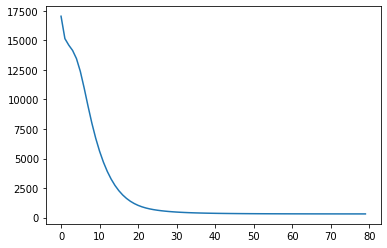

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(epochs)
plt.plot(x,l)

# GMF 

In [ ]:
class GMF(nn.Module):
  def __init__(self, n_users, n_items, n_factors=5):
    super().__init__()
    self.user_emb = nn.Embedding(n_users,n_factors)
    self.item_emb = nn.Embedding(n_items,n_factors)
    self.h_out = nn.Linear(n_factors,1)
  
  def forward(self, user, item):
    p = self.user_emb(user)
    q = self.item_emb(item)
    return torch.flatten(self.h_out(p*q))

  def predict(self, user, item):
    return torch.sigmoid(self.forward(user, item))

  def forward_no_h(self, df):
    user_id = Variable(torch.LongTensor(df.user_id.to_numpy()))
    beer_id = Variable(torch.LongTensor(df.beer_id.to_numpy()))
    p = self.user_emb(user_id)
    q = self.item_emb(beer_id)
    return p*q 

In [ ]:
gen_mf =  GMF(n_users,n_items)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(gen_mf.parameters(),lr=1e-2)
epochs = 100
batch_size = 1000

l = []
for i in range(epochs):
    print("epoch: ",i)
    s = 0
    for bid in range(len(train_data) // batch_size):
        if (bid % 500 == 0):
          print("iteration: ",i, ", batch: ", bid) # there are around 2000 batches per iteration, you may want to print the batch number to check the curret progress
        data = train_data[bid * batch_size : (bid + 1) * batch_size]
        optimizer.zero_grad()

        rating = Variable(torch.FloatTensor(data.relevant.to_numpy()))
        user_id = Variable(torch.LongTensor(data.user_id.to_numpy()))
        beer_id = Variable(torch.LongTensor(data.beer_id.to_numpy()))
        pred = gen_mf.forward(user_id, beer_id)
        loss = loss_fn(pred,rating)

        loss.backward()
        s += loss
        optimizer.step()
    l.append(s.item()/(len(data) // batch_size))
    print("Average Loss for the current iteration: ", l[i])
    print("-----------------------------------")

epoch:  0
iteration:  0 , batch:  0
iteration:  0 , batch:  500
Average Loss for the current iteration:  616.7832641601562
-----------------------------------
epoch:  1
iteration:  1 , batch:  0
iteration:  1 , batch:  500
Average Loss for the current iteration:  614.8677978515625
-----------------------------------
epoch:  2
iteration:  2 , batch:  0
iteration:  2 , batch:  500
Average Loss for the current iteration:  614.9588012695312
-----------------------------------
epoch:  3
iteration:  3 , batch:  0
iteration:  3 , batch:  500
Average Loss for the current iteration:  611.4109497070312
-----------------------------------
epoch:  4
iteration:  4 , batch:  0
iteration:  4 , batch:  500
Average Loss for the current iteration:  603.89013671875
-----------------------------------
epoch:  5
iteration:  5 , batch:  0
iteration:  5 , batch:  500
Average Loss for the current iteration:  591.7860717773438
-----------------------------------
epoch:  6
iteration:  6 , batch:  0
iteration:  

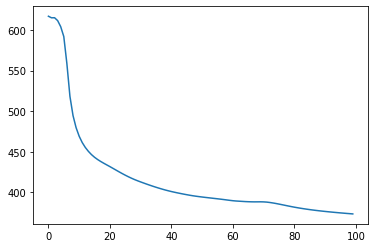

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(epochs)
plt.plot(x,l)

In [ ]:
val_rating = Variable(torch.FloatTensor(val_data.relevant.to_numpy()))
val_user_id = Variable(torch.LongTensor(val_data.user_id.to_numpy()))
val_beer_id = Variable(torch.LongTensor(val_data.beer_id.to_numpy()))
val_pred = gen_mf.predict(val_user_id,val_beer_id)
val_loss = loss_fn(val_pred,val_rating)
print(val_pred)
print(val_loss)
val_target = val_rating.numpy()
val_pred_binary = (val_pred > 0.5).numpy().astype(int)
val_acc = accuracy(val_pred_binary,val_target)
print(val_acc)

tensor([0.8076, 0.7372, 0.6327,  ..., 0.3900, 0.5223, 0.9871],
       grad_fn=<SigmoidBackward>)
tensor(0.6220, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
0.6797824494024307


In [ ]:
test_forward = gen_mf.forward_no_h(test_data)
print(test_forward.size())
print(test_forward)

torch.Size([300827, 5])
tensor([[ 7.2737e-01,  4.5568e-02,  2.3206e-03, -8.4501e+00, -2.1697e-02],
        [-2.3644e-01,  1.4754e-02,  5.4117e-04, -1.6751e+01,  1.7538e-02],
        [-6.3836e-01,  3.8685e-03, -4.9599e-04, -1.2303e+01, -3.8737e-02],
        ...,
        [ 6.6807e+00,  5.1221e+00, -8.6250e+01,  1.5875e+02, -1.0042e+01],
        [ 3.7505e+01,  1.4668e+00,  2.6884e+01,  1.3622e+02, -3.1027e+00],
        [ 5.8637e+00, -1.0669e+01, -8.2789e+01, -3.6648e+01, -4.2017e+00]],
       grad_fn=<MulBackward0>)


In [ ]:
torch.save(gen_mf.state_dict(), "/content/drive/MyDrive/CS247/Models/checkpoints/gmf.pth")

In [ ]:
saved_model =  GMF(n_users,n_items)
saved_model.load_state_dict(torch.load("/content/drive/MyDrive/CS247/Models/checkpoints/gmf.pth"))
test_forward = saved_model.forward_no_h(test_data)
print(test_forward)

tensor([[ 7.2737e-01,  4.5568e-02,  2.3206e-03, -8.4501e+00, -2.1697e-02],
        [-2.3644e-01,  1.4754e-02,  5.4117e-04, -1.6751e+01,  1.7538e-02],
        [-6.3836e-01,  3.8685e-03, -4.9599e-04, -1.2303e+01, -3.8737e-02],
        ...,
        [ 6.6807e+00,  5.1221e+00, -8.6250e+01,  1.5875e+02, -1.0042e+01],
        [ 3.7505e+01,  1.4668e+00,  2.6884e+01,  1.3622e+02, -3.1027e+00],
        [ 5.8637e+00, -1.0669e+01, -8.2789e+01, -3.6648e+01, -4.2017e+00]],
       grad_fn=<MulBackward0>)


In [ ]:
label_pred = 'y_pred'
user_id = Variable(torch.LongTensor(test_data.user_id.to_numpy()))
beer_id = Variable(torch.LongTensor(test_data.beer_id.to_numpy()))

test_data[label_pred] = (saved_model.predict(user_id,beer_id)>0.5).cpu().detach().numpy().astype(int)
test_prec, test_recall = precision_recall_at_k(test_data, label_pred=label_pred, threshold=threshold, k=5)
test_data

,user_id,beer_id,review_overall,relevant,y_pred
0,0,5892,4.0,1,1
1,2,5892,4.0,1,1
2,9,5892,4.0,1,1
3,12,5892,4.0,1,1
4,17,5892,5.0,1,1
...,...,...,...,...,...
300822,14731,14334,2.5,0,0
300823,14776,42943,4.5,1,0
300824,14780,22042,4.5,1,0
300825,14785,36467,3.5,0,0


In [ ]:
print("precision at 5 for test set: ", sum(prec for prec in test_prec.values()) / len(test_prec))
print("recall at 5 for test set:", sum(rec for rec in test_recall.values()) / len(test_prec))

precision at 5 for test set:  0.6198022923281451
recall at 5 for test set: 0.45612422165062805
